<a href="https://colab.research.google.com/github/sayanbanerjee32/lang_detect/blob/main/langid_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# mount gdrive for data.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# file locations
tar_file_loc = '/content/drive/MyDrive/lang_detection/data/sentences.tar.bz2'
dest_loc = '/tmp'
file_name = 'sentences.csv'
num_languages = 100

In [6]:
import pandas as pd
import tarfile
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [7]:
# extrtract tar file
tar = tarfile.open(tar_file_loc, "r:bz2")  
tar.extractall(path = dest_loc)
tar.close()

In [8]:
# read lines to understand structure
with open(dest_loc +'/' + file_name) as file:
    lines = file.readlines()
    lines = [line.strip() for line in lines]

In [ ]:
# see few samples
lines[0:10]

['1\tcmn\t我們試試看！',
 '2\tcmn\t我该去睡觉了。',
 '3\tcmn\t你在干什麼啊？',
 '4\tcmn\t這是什麼啊？',
 '5\tcmn\t今天是６月１８号，也是Muiriel的生日！',
 '6\tcmn\t生日快乐，Muiriel！',
 '7\tcmn\tMuiriel现在20岁了。',
 '8\tcmn\t密码是"Muiriel"。',
 '9\tcmn\t我很快就會回來。',
 '10\tcmn\t我不知道。']

In [9]:
# read data in pandas
sent_df = pd.read_csv(dest_loc +'/' + file_name, sep = '\t', names = ['id','label','text'])
sent_df.head()

,id,label,text
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！


In [10]:
# is there blank label
sent_df['label'].fillna('unk',inplace  = True)
sent_df.loc[sent_df['label'] == 'unk',:]

,id,label,text
387366,404564,unk,Lèu gāi dịdiang?
387368,404566,unk,Kuăilāk sí mitgāi?
387372,404570,unk,Dó Hānggok nạng dăn mitgāi uẹ?
388306,405522,unk,Lèu kiá dịgŏ?
388307,405523,unk,Lèu miān mitgāi?
388308,405524,unk,Uà sí Diōjiunāng.
4655179,4962310,unk,厝漏閣抵著透暝雨。
5786464,6142175,unk,我昨暗睏十一點鐘久。
5786465,6142176,unk,阮阿叔有去過芬蘭。
5786466,6142177,unk,阮佇厝裡攏講台語。


In [11]:
# is there blank texts
sent_df.loc[sent_df['text'].isnull(),:].shape, sent_df.loc[sent_df['text'] == '',:].shape

((0, 3), (0, 3))

In [12]:
# remove records where label not known
sent_df = sent_df.loc[sent_df['label'] != 'unk',:]
len(sent_df['label'].unique())

402

In [13]:
# create test split
def get_train_test_split(df):
    train_ids, test_ids = next(StratifiedKFold(n_splits=5,random_state=1).split(df.id, df.label))
    print(f"Test: {len(test_ids)}, Train: {len(train_ids)}, Total: {len(df)}")
    dummy = [False] * len(df)
    com_list = dummy[:]
    for index in test_ids: com_list[index] = True
    return com_list

In [14]:
train_test_bool = get_train_test_split(sent_df)
sum(train_test_bool)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Test: 1977424, Train: 7909695, Total: 9887119


1977424

In [15]:
# keep test separate
test_df = sent_df.loc[train_test_bool,:]
test_df.shape

(1977424, 3)

In [16]:
# Training df
train_df = sent_df.loc[list(~np.array(train_test_bool)),:]
train_df.shape

(7909695, 3)

## Langid.py

In [1]:
%%capture
!pip install langid
!pip install pycountry

In [2]:
import pycountry
import langid

In [3]:
# list of supported languages
lang_id_langs = 'af, am, an, ar, as, az, be, bg, bn, br, bs, ca, cs, cy, da, de, dz, el, en, eo, es, et, eu, fa, fi, fo, fr, ga, gl, gu, he, hi, hr, ht, hu, hy, id, is, it, ja, jv, ka, kk, km, kn, ko, ku, ky, la, lb, lo, lt, lv, mg, mk, ml, mn, mr, ms, mt, nb, ne, nl, nn, no, oc, or, pa, pl, ps, pt, qu, ro, ru, rw, se, si, sk, sl, sq, sr, sv, sw, ta, te, th, tl, tr, ug, uk, ur, vi, vo, wa, xh, zh, zu'
lang_id_langs = [l.strip() for l in lang_id_langs.split(',')]
# convert the ISO-3 code for comparison
lang_id_langs = [pycountry.languages.get(alpha_2 = l).alpha_3 for l in lang_id_langs]
len(lang_id_langs)

97

In [17]:
# number of languages that are common
len(set(lang_id_langs).intersection(set(test_df['label'].unique())))

88

## Test

In [ ]:
# create test subsample based on supported languages
trained_labels = lang_id_langs
# train_sub_sample.label.unique()
test_sub_sample = test_df.loc[test_df['label'].isin(trained_labels)]
test_sub_sample.shape,test_df.shape

((1696972, 3), (1977424, 3))

In [ ]:
# detection function with langid
def get_predicted_data(test_df):
    test_df['predicted_label'] = test_df['text'].apply(lambda x: pycountry.languages.get(alpha_2 =langid.classify(x)[0]).alpha_3)
    return test_df

In [ ]:
pred_df = get_predicted_data(test_sub_sample)
pred_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,label,text,predicted_label
75,77,deu,Lass uns etwas versuchen!,eng
76,78,deu,Ich muss schlafen gehen.,deu
77,80,deu,Was ist das?,deu
78,81,deu,Heute ist der 18. Juni und das ist der Geburts...,deu
79,82,deu,"Herzlichen Glückwunsch zum Geburtstag, Muiriel!",deu


### Performance metrics

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(pred_df['label'], pred_df['predicted_label'])
print(classification_report(pred_df['label'], pred_df['predicted_label']))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         afr       0.33      0.49      0.39       806
         amh       0.75      1.00      0.86        42
         ara       1.00      0.95      0.97      7597
         arg       0.01      0.10      0.01        21
         asm       0.92      0.23      0.37       639
         aze       0.25      0.74      0.38      1081
         bel       0.41      0.87      0.56      2528
         ben       0.66      0.99      0.79       946
         bos       0.01      0.05      0.02       123
         bre       0.45      0.66      0.54      1454
         bul       0.19      0.59      0.29      4900
         cat       0.20      0.73      0.32      1596
         ces       0.89      0.86      0.88     11993
         cym       0.33      0.72      0.45       307
         dan       0.74      0.59      0.66     10138
         deu       0.95      0.98      0.96    113629
         ell       1.00      1.00      1.00      6861
         eng       0.96    

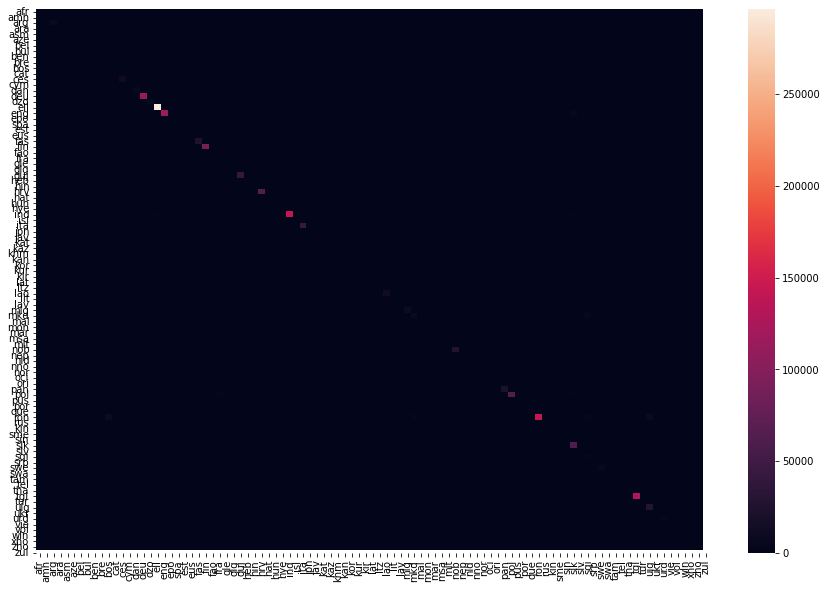

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = False, xticklabels=trained_labels,yticklabels=trained_labels)
plt.show()